In [13]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K
from tcn import TCN
from keras import regularizers

# Import data

In [1]:
training_df_raw=pd.read_csv("0.5s_raw_range_A1_A2_A3_no_overlap.csv")
#training_df=pd.read_csv("0.5s_spec_range_A1_A2_A3_no_overlap.csv")

NameError: name 'pd' is not defined

#  Range Estimation dataset creation

In [308]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges
def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,-256:])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<100:
                        data=data[0]
                        data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        twd_frame.append(data)
                        range_frame.append(dist)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

Error evaluating: thread_id: pid_13972_id_2022270067136
frame_id: 2025208993584
scope: FRAME
attrs: training_df_raw
Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_vars.py", line 314, in resolve_compound_variable_fields
    return _typeName, _resolve_default_variable_fields(var, resolver, offset)
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_vars.py", line 264, in _resolve_default_variable_fields
    return resolver.get_dictionary(VariableWithOffset(var, offset) if offset else var)
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_resolver.py", line 86, in get_dictionary
    return self._getPyDictionary(var, names)
  File "C:\Program Files\JetBrains\PyCharm 2021.3.2\plugins\python\helpers\pydev\_pydevd_bundle\pydevd_resolver.py", line 195, in _getPyDictionary
    d[ n ] = attr
KeyboardInte

NameError: name 'training_df' is not defined

In [ ]:
x_data=np.array(x_data)
#x_data=np.transpose(x_data,axes=[0,2,1])
y_data=np.array(y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)
input_shape=(4,64,1)

In [ ]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x]==3 and rand_vals==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)

# Classification Dataset Creation

In [3]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    elif distance>80:
        class_val=3

    return class_val

def classFinderv2(distance):
    if distance<30:
        class_val=0
    elif distance<=40:
        class_val=1
    elif distance<=50:
        class_val=2
    elif distance<=60:
        class_val=3
    elif distance<=70:
        class_val=4
    elif distance<=80:
        class_val=5
    else:
        class_val=6
    return class_val
def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,-256:])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    #if np.array(dist)[0]<100:
                    data=data[0]
                    data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                    dist=np.array(dist)[0]
                    class_value=classFinder(dist)
                    twd_frame.append(data)
                    range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))


KeyboardInterrupt



# Classification with raw data

In [3]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
raw_x_data=[]
raw_y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    else:
        class_val=3
    return class_val

def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice or full_name in good_runs_phantom or full_name in good_runs_IF:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250 and  not(38<np.array(dist)[0]<42) and not(58<np.array(dist)[0]<62) and not(78<np.array(dist)[0]<82) :
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(data)
                        range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            raw_x_data.extend(np.array(twd_frame))
            raw_y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3


KeyboardInterrupt: 

In [592]:
def subsample_raw(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x]==3 and rand_vals[0]==2:
        #if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
raw_x_data=np.array(raw_x_data)
raw_x_data=np.float32(raw_x_data)
raw_y_data=np.array(raw_y_data)
x_raw,y_raw=subsample_raw(raw_x_data,raw_y_data)
train_feats_raw,test_feats_raw,train_targs_raw,test_targs_raw=train_test_split(x_raw,y_raw,test_size=0.2,shuffle=True,random_state=42)
range_train_targs_raw=train_targs_raw[:]
# range_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=4)
# range_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=4)
#class_train_targs_oh_raw=tf.keras.utils.to_categorical(class_train_targs_raw,num_classes=3)
range_train_targs_oh_raw=tf.keras.utils.to_categorical(range_train_targs_raw,num_classes=4)
#class_test_targs_raw=test_targs_raw[:,1]
#cont_range_test_raw_targs=test_targs_raw[:,2]
range_test_targs_raw=test_targs_raw[:]
#class_test_targs_oh_raw=tf.keras.utils.to_categorical(class_test_targs_raw,num_classes=3)
range_test_targs_oh_raw=tf.keras.utils.to_categorical(range_test_targs_raw,num_classes=4)

(array([7631.,    0.,    0., 4452.,    0.,    0., 5298.,    0.,    0.,
        6802.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

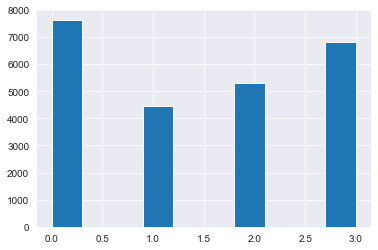

In [593]:
plt.hist(y_raw)

In [594]:
from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(class_train_targs), y=class_train_targs)
# class_weights={0:class_weights[0], 1:class_weights[1]}
#print(class_weights)
range_weights_raw=class_weight.compute_class_weight('balanced', classes=np.unique(range_train_targs_raw), y=range_train_targs_raw)
#,4:range_weights[4],5:range_weights[5], 6:range_weights[6]
range_weights_raw={0:range_weights_raw[0], 1:range_weights_raw[1],2:range_weights_raw[2], 3:range_weights_raw[3]}
print(range_weights_raw)

{0: 0.7917007693566869, 1: 1.3524888143176734, 2: 1.1337318330989217, 3: 0.8964782205746061}


In [ ]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5)
kf.get_n_splits(X=train_targs, y=train_targs)

# From raw to actual data

In [4]:
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
x_data=[]
y_data=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_IF:
        drone_type=1
    elif full_name in good_runs_matrice:
        drone_type=0
    else:
        drone_type=2
    if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom:
    #if full_name in good_runs_phantom:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
                #data=np.array(frame_df.iloc[:,8:16008])
                if np.any(data):
                    mel_data=melspect(data[0],8000)
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250 and  not(38<np.array(dist)[0]<42) and not(58<np.array(dist)[0]<62) and not(78<np.array(dist)[0]<82) :
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(mel_data)
                        range_frame.append([class_value,drone_type,dist])
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


In [48]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x][0]==3 and rand_vals[0]==2:
        #if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x][0] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
x_data=np.array(x_data)
x_data=np.float32(x_data)
y_data=np.array(y_data)
x__,y__=subsample(x_data,y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x__,y__,test_size=0.2,shuffle=True,random_state=42)
class_train_targs=train_targs[:,1]
cont_range_train_targs=train_targs[:,2]
range_train_targs=train_targs[:,0]
# range_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=4)
# range_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=4)
class_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=3)
range_train_targs_oh=tf.keras.utils.to_categorical(range_train_targs,num_classes=4)
class_test_targs=test_targs[:,1]
cont_range_test_targs=test_targs[:,2]
range_test_targs=test_targs[:,0]
class_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=3)
range_test_targs_oh=tf.keras.utils.to_categorical(range_test_targs,num_classes=4)

KeyboardInterrupt: 

In [73]:
if_train_data=[]
if_test_data=[]
matrice_train_data=[]
matrice_test_data=[]
phantom_train_data=[]
phantom_test_data=[]
if_train_targs=[]
if_test_targs=[]
matrice_train_targs=[]
matrice_test_targs=[]
phantom_train_targs=[]
phantom_test_targs=[]
for x in range(len(train_targs)):
    if train_targs[x][1]==0:
        matrice_train_data.append(train_feats[x])
        matrice_train_targs.append(train_targs[x][0])
    elif train_targs[x][1]==1:
        if_train_data.append(train_feats[x])
        if_train_targs.append(train_targs[x][0])
    elif train_targs[x][1]==2:
        phantom_train_data.append(train_feats[x])
        phantom_train_targs.append(train_targs[x][0])

for x in range(len(test_targs)):
    if test_targs[x][1]==0:
        matrice_test_data.append(test_feats[x])
        matrice_test_targs.append(test_targs[x][0])
    elif test_targs[x][1]==1:
        if_test_data.append(test_feats[x])
        if_test_targs.append(test_targs[x][0])
    elif test_targs[x][1]==2:
        phantom_test_data.append(test_feats[x])
        phantom_test_targs.append(test_targs[x][0])

array([3., 0., 3., ..., 0., 0., 0.])

In [172]:
#plt.hist(train_targs[:,0])
# plt.xlabel("Class")
# plt.ylabel("Samples")
# plt.title("Combined Dataset")
#plt.savefig("combinedDistro.pdf")
#len((train_targs[:,0]))
# 0.3378, 0.16566, 0.176591, 31988
correct=0
pred=0
total=0
rng=np.random.default_rng(12345)
for x in range(len(test_targs)):
    rand_vals=rng.integers(low=1,high=100,size=1)
    if rand_vals[0]<34:
        pred=0
    elif rand_vals[0]<50:
        pred=1
    elif rand_vals[0]<68:
        pred=2
    else:
        pred=3
    if(test_targs[x][0]==pred):
        correct+=1
    total+=1
correct/total

0.2649753347427766

In [150]:
from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(class_train_targs), y=class_train_targs)
# class_weights={0:class_weights[0], 1:class_weights[1]}
#print(class_weights)
range_weights=class_weight.compute_class_weight('balanced', classes=np.unique(phantom_train_targs), y=phantom_train_targs)
#,4:range_weights[4],5:range_weights[5], 6:range_weights[6]
range_weights={0:range_weights[0], 1:range_weights[1],2:range_weights[2], 3:range_weights[3]}
print(range_weights)

{0: 0.9723385167464115, 1: 1.2033678756476685, 2: 1.523664479850047, 3: 0.6737463738085371}


[ 0.          1.         31.91555911]


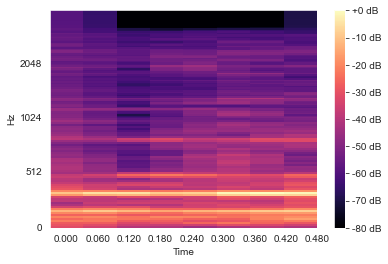

In [526]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(x_data[1500], ref=np.max)
print(y_data[1500])
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
plt.savefig("melspect.pdf")

# Multiclass Clasification with multiple outputs

In [60]:
# modelCNN=tf.keras.Sequential()
# modelCNN.add(BatchNormalization(input_shape=(128,8,1)))
# modelCNN.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
# modelCNN.add(BatchNormalization())
# modelCNN.add(Activation('relu'))
# modelCNN.add(MaxPooling2D(2,2))
# modelCNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
#                          padding='SAME', name='conv_2'))
# modelCNN.add(BatchNormalization())
# modelCNN.add(Activation('relu'))
# modelCNN.add(Dropout(0.3))
# modelCNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
#                          padding='SAME', name='conv_3'))
# modelCNN.add(BatchNormalization())
# modelCNN.add(Activation('relu'))
# modelCNN.add(Dropout(0.3))
# modelCNN.add(Flatten())
# modelCNN.add(Dense(512, activation='relu', name='dense_2'))
# modelCNN.add(Dense(256, activation='relu', name='dense_3'))
# modelCNN.add(Dropout(0.5))
# modelCNN.add(Dense(4, activation='softmax', name='dense_4'))
#modelCNN=tf.keras.Functional()
inputs= Input(shape=(128,8,1),name='input')
hidden=BatchNormalization(input_shape=(128,8,1))(inputs)
hidden=Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1')(hidden)
hidden=BatchNormalization()(hidden)
hidden=Activation('relu')(hidden)
hidden=MaxPooling2D(2,2)(hidden)
hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2')(hidden)
hidden=BatchNormalization()(hidden)
hidden=Activation('relu')(hidden)
hidden=Dropout(0.3)(hidden)
hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
                         padding='SAME', name='conv_3')(hidden)
hidden=BatchNormalization()(hidden)
hidden=Activation('relu')(hidden)
hidden=Dropout(0.3)(hidden)
hidden=Flatten()(hidden)
hidden=Dense(512, activation='relu', name='dense_2')(hidden)
hidden=Dense(256, activation='relu', name='dense_3')(hidden)
hidden=Dropout(0.5)(hidden)
output1=Dense(4, activation='softmax', name='output_range')(hidden)
output2=Dense(3,activation='softmax',name="output_class")(hidden)
#output3=Dense(1,activation='linear',name="output_cont_range")(hidden)


modelCNN=Model(inputs=inputs,outputs=[output1,output2])
optimizer= tf.keras.optimizers.Adam()
modelCNN.compile(loss={'output_range':'categorical_crossentropy',
                       'output_class':'categorical_crossentropy'},optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
modelCNN.build(input_shape=(None,128,8,1))
modelCNN.summary()
history = modelCNN.fit(train_feats, {'output_range':range_train_targs_oh,'output_class': class_train_targs_oh},
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      #class_weight={'output_1':range_weights,'output_2': class_weights},
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 8, 1)]  0           []                               
                                                                                                  
 batch_normalization_62 (BatchN  (None, 128, 8, 1)   4           ['input[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 8, 32)   128         ['batch_normalization_62[0][0]'] 
                                                                                                  
 batch_normalization_63 (BatchN  (None, 128, 8, 32)  128         ['conv_1[0][0]']             

KeyboardInterrupt: 

In [129]:
score = modelCNN.predict(test_feats)
modelCNN.evaluate(test_feats,y={'output_range':range_test_targs_oh,'output_class':class_test_targs_oh})
test_predictions=modelCNN.predict(test_feats)

152/152 [==============================] - 1s 8ms/step


Text(0.5, 1.0, 'Combined Class  Conf. Matrix')

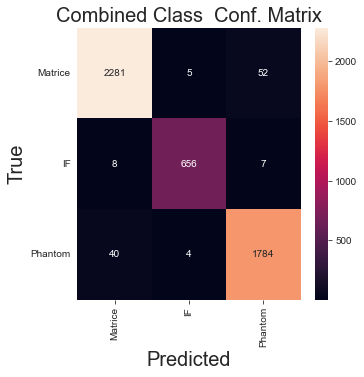

In [130]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(test_predictions[1],axis=-1)
y_true=np.argmax(class_test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["Matrice","IF","Phantom"]
#class_names = ["<40","40-60","60-80",">80"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Combined Class  Conf. Matrix', fontsize=20)

In [132]:
print(classification_report(y_true=y_true,y_pred=y_pred)) #this is using the multi-output regression/classification

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2338
           1       0.99      0.98      0.98       671
           2       0.97      0.98      0.97      1828

    accuracy                           0.98      4837
   macro avg       0.98      0.98      0.98      4837
weighted avg       0.98      0.98      0.98      4837



Text(0.5, 1.0, 'CNN (Multi-out) Combined Matrice Confusion Matrix')

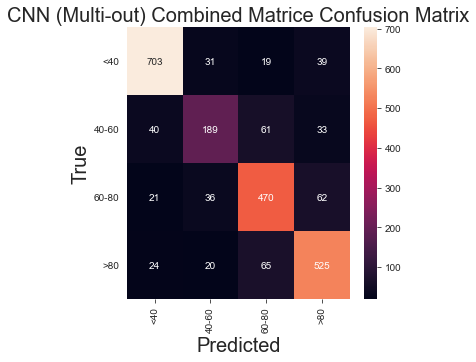

In [143]:
single_drone_truth=[]
single_drone_pred=[]
for x in range(len(class_test_targs)):
    if class_test_targs[x]==0:
        single_drone_truth.append(np.argmax(range_test_targs_oh[x], axis=-1))
        single_drone_pred.append(np.argmax(test_predictions[0][x], axis=-1))
        cm = confusion_matrix(single_drone_truth, single_drone_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CNN (Multi-out) Combined Matrice Confusion Matrix', fontsize=20)


In [144]:
print(classification_report(y_true=single_drone_truth,y_pred=single_drone_pred)) #this is using the multi-output regression/classification

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       792
           1       0.68      0.59      0.63       323
           2       0.76      0.80      0.78       589
           3       0.80      0.83      0.81       634

    accuracy                           0.81      2338
   macro avg       0.78      0.77      0.78      2338
weighted avg       0.81      0.81      0.81      2338



# Multiclass classification

In [112]:
modelCNN_MC=tf.keras.Sequential()
modelCNN_MC.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MC.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MC.add(BatchNormalization())
modelCNN_MC.add(Activation('relu'))
modelCNN_MC.add(MaxPooling2D(2))
modelCNN_MC.add(Conv2D(filters=32,kernel_size=(4,4),strides=(1,1), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MC.add(BatchNormalization())
modelCNN_MC.add(Activation('relu'))
modelCNN_MC.add(Dropout(0.3))
modelCNN_MC.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MC.add(BatchNormalization())
modelCNN_MC.add(Activation('relu'))
modelCNN_MC.add(MaxPooling2D(2))
modelCNN_MC.add(Dropout(0.3))
modelCNN_MC.add(Flatten())
modelCNN_MC.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MC.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MC.add(Dropout(0.5))
modelCNN_MC.add(Dense(4, activation='softmax', name='output_range'))
# inputs= Input(shape=(128,8,1),name='input')
# hidden=BatchNormalization(input_shape=(128,8,1))(inputs)
# hidden=Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=MaxPooling2D(2,2)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
#                          padding='SAME', name='conv_2')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
#                          padding='SAME', name='conv_3')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Flatten()(hidden)
# hidden=Dense(512, activation='relu', name='dense_2')(hidden)
# hidden=Dense(256, activation='relu', name='dense_3')(hidden)
# hidden=Dropout(0.5)(hidden)
# output1=Dense(7, activation='softmax', name='output_range')(hidden)
#output2=Dense(3,activation='softmax',name="output_class")(hidden)
#output3=Dense(1,activation='linear',name="output_cont_range")(hidden)


#modelCNNv2=Model(inputs=inputs,outputs=[output1])
optimizer= tf.keras.optimizers.Adam()
modelCNN_MC.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MC.build(input_shape=(None,128,8,1))
modelCNN_MC.summary()
history = modelCNN_MC.fit(train_feats, range_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_103 (Ba  (None, 128, 8, 1)        4         
 tchNormalization)                                               
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 32)        128       
                                                                 
 batch_normalization_104 (Ba  (None, 128, 8, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_78 (Activation)  (None, 128, 8, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 4, 32)        0         
 g2D)                                                            
                                                     

# Max val 0.7692

In [113]:
MLtools.save_model(modelCNN_MCV2,"localization_CNNV2(best)_090222")

In [156]:
test_targs_oh=tf.keras.utils.to_categorical(phantom_test_targs,num_classes=4)
score = modelCNN_MCV2.predict(np.array(phantom_test_data))
modelCNN_MCV2.evaluate(np.array(phantom_test_data),y={'output_range':test_targs_oh})
#test_predictions=modelCNN_MCV2.predict(test_feats)

51/51 [==============================] - 0s 7ms/step - loss: 0.8734 - accuracy: 0.6516


[0.8733940720558167, 0.6515527963638306]

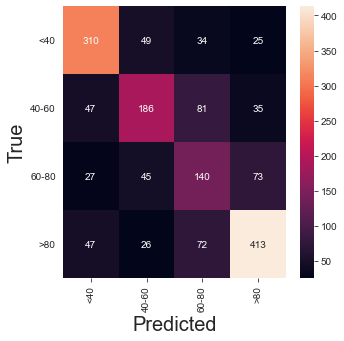

In [174]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(score,axis=-1)
y_true=np.argmax(test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

#plt.title('2DCNN Classification PhantomDS Confusion Matrix', fontsize=20)
plt.savefig("phantomds_confusion_CNNV2.pdf",bbox_inches='tight')

In [158]:
from sklearn.metrics import balanced_accuracy_score
print(classification_report(y_true=y_true,y_pred=y_pred))
print(balanced_accuracy_score(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       418
           1       0.61      0.53      0.57       349
           2       0.43      0.49      0.46       285
           3       0.76      0.74      0.75       558

    accuracy                           0.65      1610
   macro avg       0.63      0.63      0.63      1610
weighted avg       0.66      0.65      0.65      1610

0.62648738075193


In [105]:
single_drone_truth=[]
single_drone_pred=[]
for x in range(len(class_test_targs)):
    if class_test_targs[x]==2:
        single_drone_truth.append(np.argmax(range_test_targs_oh[x], axis=-1))
        single_drone_pred.append(np.argmax(test_predictions[x], axis=-1))
        cm = confusion_matrix(single_drone_truth, single_drone_pred)

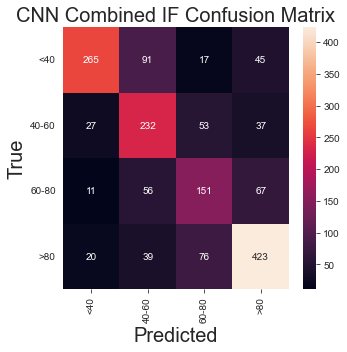

In [106]:
cm = confusion_matrix(single_drone_truth, single_drone_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CNN Combined IF Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.savefig("IF_CM.pdf")

In [104]:
print(classification_report(y_true=single_drone_truth,y_pred=single_drone_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       748
           1       0.61      0.68      0.64       265
           2       0.74      0.77      0.75       435
           3       0.85      0.83      0.84       625

    accuracy                           0.82      2073
   macro avg       0.78      0.79      0.79      2073
weighted avg       0.83      0.82      0.82      2073



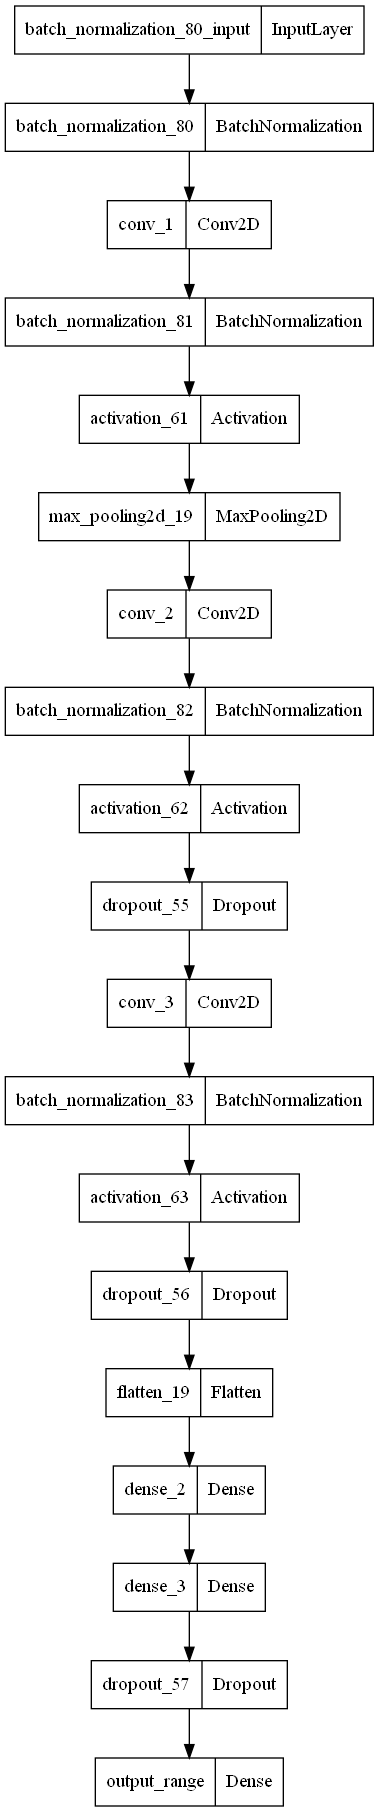

In [111]:
tf.keras.utils.plot_model(modelCNN_MC)

# Best performing model

In [153]:
modelCNN_MCV2=tf.keras.Sequential()
modelCNN_MCV2.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MCV2.add(Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(MaxPooling2D(2))
modelCNN_MCV2.add(Conv2D(filters=16,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Conv2D(filters=32,kernel_size=(2,2),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV2.add(BatchNormalization())
modelCNN_MCV2.add(Activation('relu'))
modelCNN_MCV2.add(Dropout(0.3))
modelCNN_MCV2.add(Flatten())
modelCNN_MCV2.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MCV2.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MCV2.add(Dropout(0.5))
modelCNN_MCV2.add(Dense(4, activation='softmax', name='output_range'))
# inputs= Input(shape=(128,8,1),name='input')
# hidden=BatchNormalization(input_shape=(128,8,1))(inputs)
# hidden=Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=MaxPooling2D(2,2)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
#                          padding='SAME', name='conv_2')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
#                          padding='SAME', name='conv_3')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Flatten()(hidden)
# hidden=Dense(512, activation='relu', name='dense_2')(hidden)
# hidden=Dense(256, activation='relu', name='dense_3')(hidden)
# hidden=Dropout(0.5)(hidden)
# output1=Dense(7, activation='softmax', name='output_range')(hidden)
#output2=Dense(3,activation='softmax',name="output_class")(hidden)
#output3=Dense(1,activation='linear',name="output_cont_range")(hidden)


#modelCNNv2=Model(inputs=inputs,outputs=[output1])
optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV2.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV2.build(input_shape=(None,128,8,1))
modelCNN_MCV2.summary()
single_drone_train_targs_oh=tf.keras.utils.to_categorical(phantom_train_targs,num_classes=4)
single_drone_train_data=np.array(phantom_train_data)
history = modelCNN_MCV2.fit(single_drone_train_data, single_drone_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_131 (Ba  (None, 128, 8, 1)        4         
 tchNormalization)                                               
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 8)         128       
                                                                 
 batch_normalization_132 (Ba  (None, 128, 8, 8)        32        
 tchNormalization)                                               
                                                                 
 activation_99 (Activation)  (None, 128, 8, 8)         0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 64, 4, 8)         0         
 g2D)                                                            
                                                     

In [63]:
modelCNN_MCV3=tf.keras.Sequential()
modelCNN_MCV3.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MCV3.add(Conv2D(filters=4,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MCV3.add(BatchNormalization())
modelCNN_MCV3.add(Activation('relu'))
#modelCNN_MCV3.add(MaxPooling2D(2))
modelCNN_MCV3.add(Conv2D(filters=8,kernel_size=(2,2),strides=(1,1), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MCV3.add(BatchNormalization())
modelCNN_MCV3.add(Activation('relu'))
modelCNN_MCV3.add(Dropout(0.3))
modelCNN_MCV3.add(Conv2D(filters=16,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MCV3.add(BatchNormalization())
modelCNN_MCV3.add(Activation('relu'))
modelCNN_MCV3.add(Conv2D(filters=64,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_4'))
modelCNN_MCV3.add(BatchNormalization())
modelCNN_MCV3.add(Activation('relu'))
modelCNN_MCV3.add(Dropout(0.3))
modelCNN_MCV3.add(Flatten())
#modelCNN_MCV2.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MCV3.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MCV3.add(Dropout(0.5))
modelCNN_MCV3.add(Dense(4, activation='softmax', name='output_range'))
# inputs= Input(shape=(128,8,1),name='input')
# hidden=BatchNormalization(input_shape=(128,8,1))(inputs)
# hidden=Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=MaxPooling2D(2,2)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
#                          padding='SAME', name='conv_2')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
#                          padding='SAME', name='conv_3')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Flatten()(hidden)
# hidden=Dense(512, activation='relu', name='dense_2')(hidden)
# hidden=Dense(256, activation='relu', name='dense_3')(hidden)
# hidden=Dropout(0.5)(hidden)
# output1=Dense(7, activation='softmax', name='output_range')(hidden)
#output2=Dense(3,activation='softmax',name="output_class")(hidden)
#output3=Dense(1,activation='linear',name="output_cont_range")(hidden)


#modelCNNv2=Model(inputs=inputs,outputs=[output1])
optimizer= tf.keras.optimizers.Adam()
modelCNN_MCV3.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelCNN_MCV3.build(input_shape=(None,128,8,1))
modelCNN_MCV3.summary()
history = modelCNN_MCV3.fit(train_feats, range_train_targs_oh,
                      epochs=400,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_74 (Bat  (None, 128, 8, 1)        4         
 chNormalization)                                                
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 4)         16        
                                                                 
 batch_normalization_75 (Bat  (None, 128, 8, 4)        16        
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, 128, 8, 4)         0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 8, 8)         128       
                                                                 
 batch_normalization_76 (Bat  (None, 128, 8, 8)      

# Deep Recurrent Neural Network For Ranging
Those shouldn't work unless the data is laid out so that each phone's observation extends for 300 sequential frames, then switches to the next.

Text(0.5, 1.0, 'IF CRNN Confusion Matrix')

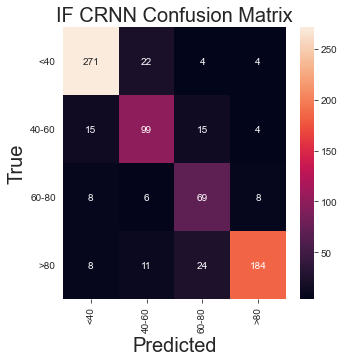

In [172]:
y_pred = np.argmax(test_predictions, axis=-1)
y_true=np.argmax(range_test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('IF CRNN Confusion Matrix', fontsize=20)

In [173]:
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       301
           1       0.72      0.74      0.73       133
           2       0.62      0.76      0.68        91
           3       0.92      0.81      0.86       227

    accuracy                           0.83       752
   macro avg       0.79      0.80      0.79       752
weighted avg       0.84      0.83      0.83       752



              precision    recall  f1-score   support

           0       0.69      0.71      0.70       456
           1       0.61      0.38      0.47       429
           2       0.44      0.51      0.47       346
           3       0.68      0.79      0.73       597

    accuracy                           0.62      1828
   macro avg       0.60      0.60      0.59      1828
weighted avg       0.62      0.62      0.61      1828



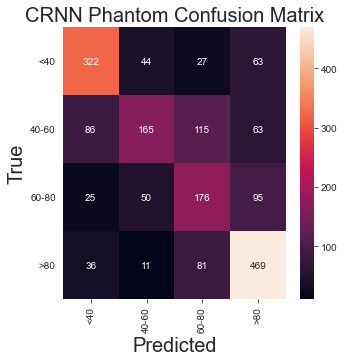

In [155]:
single_drone_truth=[]
single_drone_pred=[]
for x in range(len(class_test_targs)):
    if class_test_targs[x]==1:
        single_drone_truth.append(np.argmax(range_test_targs_oh[x], axis=-1))
        single_drone_pred.append(np.argmax(test_predictions[x], axis=-1))
        cm = confusion_matrix(single_drone_truth, single_drone_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CRNN Phantom Confusion Matrix', fontsize=20)
print(classification_report(y_true=single_drone_truth,y_pred=single_drone_pred)) #this is using the multi-output regression/classification


In [ ]:
plt.hist(y_true,alpha=0.5)
plt.hist(y_pred,alpha=0.5)
plt.show()

In [ ]:
score=np.reshape(score,-1)
residual=score-test_targs
plt.xlabel("Truth (meters)")
plt.ylabel("Error (meters)")
plt.scatter(test_targs,np.abs(residual))
plt.show()

In [ ]:
resid_df=pd.DataFrame({"Actual":test_targs,"Error":residual})

In [ ]:
ave_error=[]
sub_40=resid_df[resid_df["Actual"]<40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<60]
sub_40=sub_40[sub_40["Actual"]>40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<80]
sub_40=sub_40[sub_40["Actual"]>60]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]>80]
ave_error.append(sub_40["Error"].mean())

In [ ]:
print(ave_error)

In [ ]:
plt.hist(train_targs)

# CRNN Take 2: Trying to not have RNN part be pointless

In [64]:
modelCRNN=tf.keras.Sequential()
modelCRNN.add(BatchNormalization(input_shape=(128,8,1)))
modelCRNN.add(Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
#modelCRNN.add(MaxPooling2D(2,2))
modelCRNN.add(Conv2D(filters=16,kernel_size=(4,4),strides=(2,1), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
modelCRNN.add(Dropout(0.3))
modelCRNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,1), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('relu'))
modelCRNN.add(MaxPooling2D((12,1)))
modelCRNN.add(Dropout(0.3))
#modelCRNN.add(Flatten())
modelCRNN.add(Reshape((8,32),input_shape=(1,8,32)))
modelCRNN.add(GRU(32, input_shape=(1,8,32)))
modelCRNN.add(Dense(64, activation='relu', name='dense_3'))
modelCRNN.add(Dropout(0.5))
modelCRNN.add(Dense(4, activation='softmax', name='dense_4'))


optimizer= tf.keras.optimizers.Adam()
modelCRNN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,
                          patience=40, mode='auto', restore_best_weights=True)
modelCRNN.build(input_shape=(None,128,8,1))
modelCRNN.summary()
history = modelCRNN.fit(train_feats, range_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      class_weight=range_weights,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_79 (Bat  (None, 128, 8, 1)        4         
 chNormalization)                                                
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 8)         32        
                                                                 
 batch_normalization_80 (Bat  (None, 128, 8, 8)        32        
 chNormalization)                                                
                                                                 
 activation_60 (Activation)  (None, 128, 8, 8)         0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 8, 16)         2048      
                                                                 
 batch_normalization_81 (Bat  (None, 64, 8, 16)      

In [657]:
MLtools.save_model(modelCRNN,"localization_CRNN_083122")
MLtools.save_model(modelCRNN,"localization_1DCNN_083122")

# Deep Neural Network for Ranging
I think that the A3 data is incorrect, truth vals are incorrect, or combination. Training on A2 produces accurate results (atleast, expected, increased error as distance increases. Instead, A3 data has more have a V shaped error. I should investigate if certain phones are extremely accurate and if other phones are not as accurate.

In [330]:
modelCNN_R=tf.keras.Sequential()
modelCNN_R.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_R.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_R.add(BatchNormalization())
modelCNN_R.add(Activation('relu'))
modelCNN_R.add(MaxPooling2D(2,2))
modelCNN_R.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_R.add(BatchNormalization())
modelCNN_R.add(Activation('relu'))
modelCNN_R.add(Dropout(0.3))
modelCNN_R.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_R.add(BatchNormalization())
modelCNN_R.add(Activation('relu'))
modelCNN_R.add(Dropout(0.3))
modelCNN_R.add(Flatten())
modelCNN_R.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_R.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_R.add(Dropout(0.5))
modelCNN_R.add(Dense(1, activation='linear', name='dense_4'))


optimizer= tf.keras.optimizers.Adam()
modelCNN_R.compile(loss='mse',optimizer=optimizer,metrics=['mae','mse'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
modelCNN_R.build(input_shape=(None,128,8,1))
modelCNN_R.summary()
history = modelCNN_R.fit(train_feats, cont_range_train_targs,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      #class_weight=class_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_406 (Ba  (None, 128, 8, 1)        4         
 tchNormalization)                                               
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 32)        128       
                                                                 
 batch_normalization_407 (Ba  (None, 128, 8, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_283 (Activation)  (None, 128, 8, 32)       0         
                                                                 
 max_pooling2d_171 (MaxPooli  (None, 64, 4, 32)        0         
 ng2D)                                                           
                                                    

ValueError: in user code:

    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_120" is incompatible with the layer: expected shape=(None, 128, 8, 1), found shape=(None, 128, 32)


In [288]:
score = modelCNN_R.predict(test_feats)
modelCNN_R.evaluate(test_feats,cont_range_test_targs)

150/150 [==============================] - 1s 7ms/step - loss: 195.2740 - mae: 9.7080 - mse: 195.2740


[195.27401733398438, 9.708029747009277, 195.27401733398438]

In [289]:
cont_test_oh=[]
cont_test_preds_oh=[]
correct=0
for x in cont_range_test_targs:
    cont_test_oh.append(classFinder(x))
for x in score:
    cont_test_preds_oh.append(classFinder(x))
for x in range(len(cont_test_oh)):
    if cont_test_oh[x]==cont_test_preds_oh[x]:
        correct+=1
print(correct/len(cont_test_oh))

0.585166561910748


Text(0.5, 1.0, 'CNN Combined Regression Confusion Matrix')

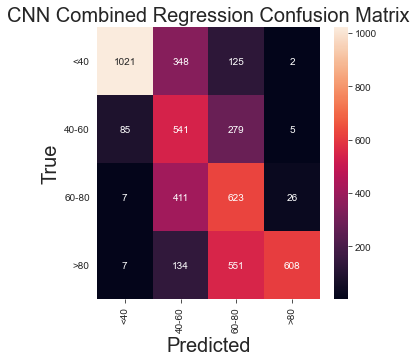

In [290]:
cm = confusion_matrix(cont_test_oh, cont_test_preds_oh)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CNN Combined Regression Confusion Matrix', fontsize=20)

In [292]:
print(classification_report(y_true=cont_test_oh,y_pred=cont_test_preds_oh))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1496
           1       0.38      0.59      0.46       910
           2       0.39      0.58      0.47      1067
           3       0.95      0.47      0.63      1300

    accuracy                           0.59      4773
   macro avg       0.66      0.58      0.58      4773
weighted avg       0.70      0.59      0.61      4773



In [279]:
plt.hist(test_targs,alpha=0.5,label="Actual")
plt.hist(score,alpha=0.5,label="Predicted")
plt.xlabel('Truth Range')
plt.legend(loc="upper right")
plt.savefig('test_distribution.pdf')

KeyboardInterrupt: 

In [ ]:
print(score)
print(len(test_targs))
score=np.reshape(score,-1)
residual=score-test_targs
print(np.shape(score))
print(np.shape(test_targs))
plt.xlabel("Truth (meters)")
plt.ylabel("Error (meters)")
plt.scatter(test_targs,np.abs(residual))
plt.show()
plt.xlabel("Truth (meters)")
plt.ylabel("Error (meters)")
plt.scatter(test_targs,residual)

In [ ]:
resid_df=pd.DataFrame({"Actual":test_targs,"Error":residual})
ave_error=[]
sub_40=resid_df[resid_df["Actual"]<40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<60]
sub_40=sub_40[sub_40["Actual"]>40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<80]
sub_40=sub_40[sub_40["Actual"]>60]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]>80]
ave_error.append(sub_40["Error"].mean())
print(ave_error)

In [ ]:
plt.xlabel('Truth Range')
plt.ylabel('Error (MAE)')
plt.bar(x=(30,50,70,90),height=ave_error,width=20)
plt.savefig('plt.pdf')

In [ ]:
MLtools.save_model(model, "CNN_model_v1_generalizable")

# LSTM with Raw Inputs

In [600]:
mean = train_feats_raw.mean(axis=0)
train_feats_raw -= mean
test_feats_raw -= mean
std = train_feats_raw.std(axis=0)
train_feats_raw /= std
test_feats_raw /= std
#train_feats_raw=np.reshape(train_feats_raw, (len(train_feats_raw), 4000, 1))
print(len(train_feats_raw))

ValueError: operands could not be broadcast together with shapes (4837,4000) (4000,1) (4837,4000) 

In [655]:
modelRaw=tf.keras.Sequential()
# This is actually >7 layers with the dilation and residual blocks
#modelRaw.add(TCN( nb_filters = 16, kernel_size=20, dilations=[1,8,32,64], name='tcn', input_shape=(4000,1)))
modelRaw.add(Conv1D(64,input_shape=[4000, 1],kernel_size=80,strides=4,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Conv1D(64,kernel_size=3,strides=2,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Dropout(0.3))
modelRaw.add(Conv1D(128,kernel_size=3,strides=1,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=4, strides=None))
modelRaw.add(Conv1D(256, kernel_size=3,strides=1,padding='same'))
modelRaw.add(BatchNormalization())
modelRaw.add(Activation('relu'))
modelRaw.add(MaxPooling1D(pool_size=2, strides=None))
modelRaw.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
modelRaw.add(Dense(4, activation='softmax'))
# modelRaw.add(Conv1D(16, kernel_size=20, padding = 'causal', dilation_rate=32, activation = 'relu', name='Conv5'))
# modelRaw.add(Conv1D(16, kernel_size=20, padding = 'causal', dilation_rate=64, activation = 'relu', name='Conv6'))
optimizer= tf.keras.optimizers.Adam()
modelRaw.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=20, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)
modelRaw.build(input_shape=(None,4000,1))
modelRaw.summary()
history = modelRaw.fit(train_feats_raw, range_train_targs_oh_raw,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1000, 64)          5184      
                                                                 
 batch_normalization_650 (Ba  (None, 1000, 64)         256       
 tchNormalization)                                               
                                                                 
 activation_418 (Activation)  (None, 1000, 64)         0         
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 250, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 125, 64)           12352     
                                                                 
 batch_normalization_651 (Ba  (None, 125, 64)       

In [455]:
test_feasts_rs=np.reshape(test_feats, (len(test_feats), 4000, 1))
score = modelRaw.predict(test_feasts_rs)
modelRaw.evaluate(test_feasts_rs,range_test_targs_oh)

152/152 [==============================] - 11s 62ms/step - loss: 0.9310 - accuracy: 0.6190


[0.9309757947921753, 0.6189786791801453]

              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1522
           1       0.44      0.53      0.48       876
           2       0.54      0.47      0.51      1032
           3       0.67      0.71      0.69      1407

    accuracy                           0.62      4837
   macro avg       0.60      0.60      0.60      4837
weighted avg       0.63      0.62      0.62      4837



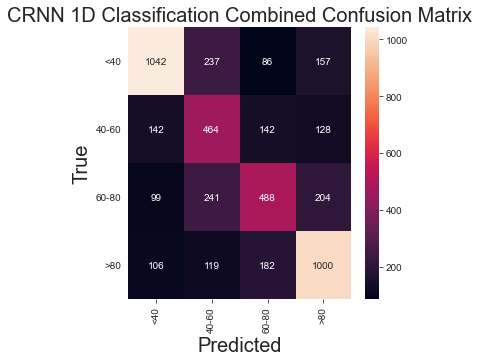

In [457]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(score,axis=-1)
y_true=np.argmax(range_test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
#class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('CRNN 1D Classification Combined Confusion Matrix', fontsize=20)
print(classification_report(y_true=y_true,y_pred=y_pred)) #this is using the multi-output regression/classification


# Generate Test dataset and test target dataset

In [ ]:
#test_df=pd.read_csv("./spec_range_A3_testset.csv")
# test_df=training_df
# def maxValueRanks(maxValArray):
#     maxValueRankArr=[]
#     for x in maxValArray:
#         seq = sorted(x)
#         index = [seq.index(v) for v in x]
#         maxValueRankArr.append(index)
#     return maxValueRankArr
test_runs_matrice=["A2R3P2"]
def rank_distances(maxValArray):
    order=maxValArray.argsort()
    ranks=order.argsort()
    return ranks
def closest_distances(maxValArray):
    count=0
    for x in maxValArray:
        if x <40:
            count+=1
    return count
def eval_rangeModel_performance(truth_data):
    pure_x_data=[]
    pure_y_data=[]
    x_data=[]
    y_data=[]
    class_range_frame=[]
    for x in passes_df.iterrows():
        row=x[1]
        pass_num=row[0]
        scenario=row[1]
        run_num=row[2]
        start=row[3]
        stop=row[4]
        drone_gps_file=row[5]
        full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
        pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
        #pass_df=training_df.loc[training_df["Pass"] == full_name]
        max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
        #max_segment=pass_df["Segment"].max()
        #for i in range(0,max_segment):
        print(full_name)
        if full_name in test_runs_matrice:
            #for phone in phone_slots:
            for i in range(0,max_segment):
                #phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
                frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
            #frame_df=pass_df.loc[pass_df["Segment"]==i]
                twd_frame=[]
                range_frame=[]
                class_range_frame=[]
            #for phone in phone_slots:
                #for i in range(0,max_segment):
                for phone in phone_slots:
                    #frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                    phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
                #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                    #data=np.array(frame_df.iloc[:,-256:])
                    data=np.array(phone_seg.iloc[:,-256:])
                # dist=phone_seg[str(notable_col_names.index('Range'))]
                    dist=phone_seg[str(notable_col_names.index('Range'))]
                #dist=phone_seg["Range"]
                    if len(np.array(dist)>0):
                        if np.array(dist)[0]<400:
                            data=data[0]
                            data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            dist=np.array(dist)[0]
                            twd_frame.append(data)
                            range_frame.append(dist)
                            class_value=classFinder(dist)
                            class_range_frame.append(class_value)
                ranks=closest_distances(np.array(range_frame))
                #y_vals= rangeClosest(range_frame)
                # if np.any(ranks):
                if ranks>0:
                    x_data.append(np.array(twd_frame))
                    y_data.append(np.array(class_range_frame))
                    pure_x_data.extend(np.array(twd_frame))
                    pure_y_data.extend(np.array(class_range_frame))
    return x_data,y_data,pure_x_data,pure_y_data

test_feats_,test_targs_,pure_x,pure_y=eval_rangeModel_performance(training_df)

In [ ]:
pure_x=np.array(pure_x)
#pure_x=np.transpose(pure_x,axes=[0,2,1])
#pure_x=np.array(pure_x).reshape(len(pure_x),4,64,1)
pure_y=np.array(pure_y)
pure_y_oh=tf.keras.utils.to_categorical(pure_y,num_classes=4)
plt.hist(pure_y)

In [ ]:
modelCNN.evaluate(pure_x,pure_y_oh)
vals=modelCNN.predict(pure_x)
#loaded_network.evaluate(pure_x,pure_y)
plt.hist(pure_y)

# Calculate % of Correct Estimates
This is done by considering how many of the predicted top 5 closest phones are truly within the top five closest phones. predicted_top_5/total_top_5

This is basically just a fancy way to check precision and recall scores for closest cellphones. For precision, make the total count include any predicted closest, for recall, make the total count include any true closest

In [ ]:
i=0
correct=0
total=0
for batches in test_feats_:
    predictions=[]
    pred=modelCNN.predict(batches)
    predictions=np.argmax(pred,axis=-1)
    #predicted_ranks=rank_distances(np.array(predictions).squeeze())
    closest=np.min(test_targs_[i])
    closest_pred=np.min(predictions)
    for x in range(len(predictions)):
        if predictions[x] ==closest_pred and test_targs_[i][x] ==closest: #if it is predicted closest and actually closest, this is correct
            correct+=1 # true positives
        # if test_targs_[i][x] == predictions[x] and test_targs_[i][x] == closest:
        #     correct+=1
        if predictions[x] ==closest_pred: # if predicted closest that increment total (all predicted positives)
             total+=1
    i+=1
print(correct/total)

In [ ]:
i=0
correct=0
total=0
for batches in test_feats_:
    #data=np.transpose(batches,axes=[0,2,1])
    predictions=[]
    for data in batches:
        data=np.reshape(data,(1,4,64,1))
        pred=model.predict(data)
        predictions.append(pred)
    predicted_ranks=rank_distances(np.array(predictions).squeeze())
    actual_ranks=test_targs_[i][1]
    print(len(predictions))
    for x in range(0,5):
        pred_index=np.where(predicted_ranks==x)
        act_rank=actual_ranks[pred_index]
        if act_rank<=1:
            correct+=1
        total+=1
    i+=1
print(correct/total)

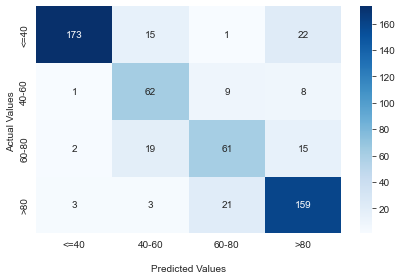

In [26]:
import seaborn as sns
cm_2DCNN_combined=[[173,15,1,22],[1,62,9,8],[2,19,61,15],[3,3,21,159]]
ax = sns.heatmap(cm_2DCNN_combined, annot=True, cmap='Blues',fmt='g')

#ax.set_title('2DCNN Trained with Combined\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["<=40","40-60","60-80",">80"])
ax.yaxis.set_ticklabels(["<=40","40-60","60-80",">80"])
## Display the visualization of the Confusion Matrix.
plt.tight_layout()
plt.savefig("2DCNN_IF(IF).pdf")

